In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import layers, models, callbacks


In [8]:
# Muat dataset
X = np.load('all_beat_segments.npy')
y = np.load('all_beat_labels_encoded.npy')

In [9]:
# Pastikan ukuran dataset
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (109459, 89)
y shape: (109459,)


In [10]:
# Split dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
# Reshape untuk model Bi-LSTM (batch_size, time_steps, features)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)


In [12]:
# Encode label ke one-hot
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [13]:
# Definisi Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.matmul(x, self.W) + self.b  # Shape: (batch_size, time_steps, 1)
        et = tf.squeeze(et, axis=-1)       # Shape: (batch_size, time_steps)
        at = tf.nn.softmax(et)            # Softmax over time steps
        at = tf.expand_dims(at, axis=-1)  # Shape: (batch_size, time_steps, 1)
        output = x * at                    # Weighted input
        output = tf.reduce_sum(output, axis=1)  # Shape: (batch_size, features)
        return output

    def get_config(self):
        return super(AttentionLayer, self).get_config()


In [14]:
# Arsitektur Model
def build_attentive_bilstm(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)

    # Attention Layer
    attention = AttentionLayer()(x)

    # Dense Layers
    x = layers.Dense(64, activation='relu')(attention)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model



In [20]:
model = build_attentive_bilstm(input_shape=(X_train.shape[1], 1), num_classes=4)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 89, 1)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 89, 128)          33792     
 nal)                                                            
                                                                 
 attention_layer_2 (Attentio  (None, 128)              217       
 nLayer)                                                         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260 

In [21]:
# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    save_best_only=True
)
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=64,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/100
1369/1369 [==============================] - 206s 146ms/step - loss: 0.3785 - accuracy: 0.8909 - val_loss: 0.2715 - val_accuracy: 0.9133
Epoch 2/100
1369/1369 [==============================] - 164s 120ms/step - loss: 0.2841 - accuracy: 0.9140 - val_loss: 0.2505 - val_accuracy: 0.9222
Epoch 3/100
1369/1369 [==============================] - 144s 105ms/step - loss: 0.2603 - accuracy: 0.9191 - val_loss: 0.2397 - val_accuracy: 0.9220
Epoch 4/100
1369/1369 [==============================] - 127s 93ms/step - loss: 0.2414 - accuracy: 0.9241 - val_loss: 0.2156 - val_accuracy: 0.9338
Epoch 5/100
1369/1369 [==============================] - 194s 142ms/step - loss: 0.2262 - accuracy: 0.9295 - val_loss: 0.2090 - val_accuracy: 0.9345
Epoch 6/100
1369/1369 [==============================] - 231s 169ms/step - loss: 0.2115 - accuracy: 0.9340 - val_loss: 0.2017 - val_accuracy: 0.9355
Epoch 7/100
1369/1369 [==============================] - 134s 98ms/step - loss: 0.2037 - accuracy: 0.9367 -

In [22]:
# Evaluasi
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

plt.figure(figsize=(12, 4))

685/685 [==============================] - 14s 21ms/step - loss: 0.1505 - accuracy: 0.9509
Test Accuracy: 0.9509


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [23]:
# Prediksi kelas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)  # Jika y_test_cat adalah one-hot

685/685 [==============================] - 14s 19ms/step


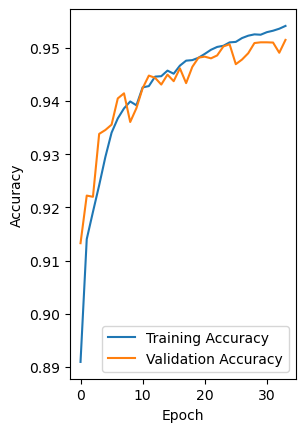

In [24]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

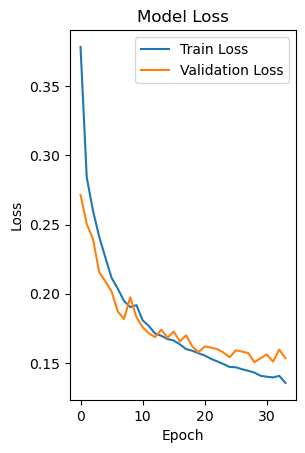

In [25]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [26]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [27]:
# Simpan model
model.save('attentive_bilstm_arrhythmia2.h5')
print("Model disimpan sebagai 'attentive_bilstm_arrhythmia2.h5'")

Model disimpan sebagai 'attentive_bilstm_arrhythmia2.h5'
